In [168]:
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

class MultiPendulum(object):
    """Class for simulating a multiple pendulum system."""
    
    def __init__(self, n):
        """Initialize a multi-pendulum with n links."""
        
        self.n = n
        self.timeseries = None
        self.q = mechanics.dynamicsymbols('theta_:{0}'.format(n))
        self.u = mechanics.dynamicsymbols('thetadot_:{0}'.format(n))

        # mass and length
        self.m = symbols('m_:{0}'.format(n))
        self.l = symbols('l_:{0}'.format(n))

        # gravity and time symbols
        self.g, self.t = symbols('g,t')
        
        # default values for mass and length
        self.lengths = np.broadcast_to(1/n, n)
        self.masses = np.broadcast_to(1.0, n)
        
        
        # Create pivot point reference frame
        A = mechanics.ReferenceFrame('A')
        P = mechanics.Point('P')
        P.set_vel(A, 0)

        # lists to hold particles, forces, and kinetic ODEs
        # for each pendulum in the chain
        particles = []
        forces = []
        kinetic_odes = []

        for i in range(n):
            # Create a reference frame following the i^th mass
            Ai = A.orientnew('A_' + str(i), 'Axis', [self.q[i], A.z])
            Ai.set_ang_vel(A, self.u[i] * A.z)

            # Create a point in this reference frame
            Pi = P.locatenew('P_' + str(i), self.l[i] * Ai.x)
            Pi.v2pt_theory(P, A, Ai)

            # Create a new particle of mass m[i] at this point
            Pai = mechanics.Particle('Pa_' + str(i), Pi, self.m[i])
            particles.append(Pai)

            # Set forces & compute kinematic ODE
            forces.append((Pi, self.m[i] * self.g * A.x))
            kinetic_odes.append(self.q[i].diff(self.t) - self.u[i])

            P = Pi

        # Generate equations of motion
        self.KM = mechanics.KanesMethod(A, q_ind=self.q, u_ind=self.u,
                                   kd_eqs=kinetic_odes)
        self.fr, self.fr_star = self.KM.kanes_equations(forces, particles)
        
        # calculate eigenmodes/eigenfrequencies
        self.calculate_linear_eigenmodes()
        
        # default times for integration
        self.times = np.linspace(0,100,10000)
        
    def set_initial_conditions(self, theta_0, omega_0, degrees=True, eigenmodes=False):
        """Set initial conditions."""
        if degrees:
            y0 = np.deg2rad(np.concatenate([np.broadcast_to(theta_0, self.n),
                                                 np.broadcast_to(omega_0, self.n)]))
        else:
            y0 = np.concatenate([np.broadcast_to(theta_0, self.n),
                                      np.broadcast_to(omega_0, self.n)])

        if eigenmodes:
            positions = (self.S * sp.Matrix([y0[0:self.n]]).T).T
            velocities = (self.S * sp.Matrix([y0[self.n:2*self.n]]).T).T
            self.y0 = np.array(positions.tolist()[0] + velocities.tolist()[0]).astype(np.float64)
            
        else:
            self.y0 = y0
            
    
    def set_lengths(self, lengths):
        """setter for lengths"""
        self.lengths = np.broadcast_to(lengths, self.n)
        # recalculate eigenmodes
        self.calculate_linear_eigenmodes()
    
    def set_masses(self, masses):
        """setter for masses"""
        self.masses = np.broadcast_to(masses, self.n)
        # recalculate eigenmodes
        self.calculate_linear_eigenmodes()
    
    def calculate_linear_eigenmodes(self):
        op_point = dict(zip(self.q+self.u, np.zeros_like(self.q+self.u)))
        A, B, C = self.KM.linearize(op_point=op_point, A_and_B=True, new_method=True)
        Asimp = -sp.simplify(A)[self.n:2*self.n, 0:self.n]
        
        parameters = [self.g] + list(self.l) + list(self.m)
        parameter_vals = [9.81] + list(self.lengths) + list(self.masses)
        Anumerical = Asimp.subs(dict(zip(parameters, parameter_vals)))
        self.S, self.D = Anumerical.diagonalize()
                
            
    def integrate(self, times=None):
        """Carry out the integration."""
        
        # deal with times argument
        if times is None:
            times = self.times
        else:
            self.times = times
        
        # Fixed parameters: gravitational constant, lengths, and masses
        parameters = [self.g] + list(self.l) + list(self.m)
        parameter_vals = [9.81] + list(self.lengths) + list(self.masses)

        # define symbols for unknown parameters
        unknowns = [Dummy() for i in self.q + self.u]
        unknown_dict = dict(zip(self.q + self.u, unknowns))
        kds = self.KM.kindiffdict()

        # substitute unknown symbols for qdot terms
        mm_sym = self.KM.mass_matrix_full.subs(kds).subs(unknown_dict)
        fo_sym = self.KM.forcing_full.subs(kds).subs(unknown_dict)

        # create functions for numerical calculation 
        mm_func = lambdify(unknowns + parameters, mm_sym)
        fo_func = lambdify(unknowns + parameters, fo_sym)

        # function which computes the derivatives of parameters
        def gradient(y, t, args):
            vals = np.concatenate((y, args))
            sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
            return np.array(sol).T[0]

        # ODE integration
        self.timeseries = odeint(gradient, self.y0, times, args=(parameter_vals,))
    
    def project_timeseries_to_eigenmodes(self):
        """Project the timeseries onto the eigenmode basis."""
        
        thetats = self.timeseries[:,0:self.n].T
        thetadotts = self.timeseries[:,self.n:2*self.n].T

        eigts = np.matmul(np.array(self.S.inv()).astype(np.float64), thetats)
        eigvts = np.matmul(np.array(self.S.inv()).astype(np.float64), thetadotts)

        self.eigts = np.vstack((eigts, eigvts)).T
    
    
    def animate(self, times=None, force=False):
        """Generate an animation"""
        
        self.integrate(times)
        x, y = get_xy_coords(self.timeseries)
    
        fig, ax = plt.subplots(figsize=(6, 6))
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        ax.axis('off')
        ax.set(xlim=(-1, 1), ylim=(-1, 1))

        line, = ax.plot([], [], 'o-', lw=2)

        def init():
            line.set_data([], [])
            return line,

        def animate(i):
            line.set_data(x[i], y[i])
            return line,

        self.anim = animation.FuncAnimation(fig, animate, frames=len(self.times),
                                            interval=1000 * self.times.max() / len(self.times),
                                            blit=True, init_func=init)
        plt.close(fig)
    
    def phase_plots(self, eigenmodes=False):
        """Make phase space plots."""
        if self.timeseries is None:
            raise ValueError("Nothing to plot!")
        
        if eigenmodes:
            coordinates = sp.symbols("phi_:{}".format(self.n))
            velocities = sp.symbols("phidot_:{}".format(self.n))
            self.project_timeseries_to_eigenmodes()
            timeseries = self.eigts
            titlestring = "Phase space plot, linear eigenmode {}"
        else:
            coordinates = self.q
            velocities = self.u
            timeseries = self.timeseries
            titlestring = "Phase space plot, pendulum {}"
        
        
        fig, ax = plt.subplots(ncols=self.n)
        fig.set_figwidth(self.n*10)
        fig.set_figheight(10)
        for idx, axis in enumerate(ax):
            axis.plot(timeseries[:,idx], timeseries[:,self.n+idx])
            axis.set_xlabel(r"${}$".format(sp.latex(coordinates[idx])), fontsize=18)
            axis.set_ylabel(r"${}$".format(sp.latex(velocities[idx])), fontsize=18)
            axis.set_title(titlestring.format(idx), fontsize=22)
        #plt.close(fig)
            
    def time_series_plots(self, eigenmodes=False):
        fig,ax = plt.subplots(nrows=4, ncols=1, sharex=True)
        fig.set_figwidth(16)
        fig.set_figheight(16)
        coordinates = list(self.q) + list(self.u)

        if eigenmodes:
            self.project_timeseries_to_eigenmodes()
            for i in range(self.n):
                ax[i].plot(self.times, self.eigts[:,i])
                ax[i].set_ylabel(r"$\phi_{}$".format(i), fontsize=16)
                ax[self.n+i].plot(self.times, self.eigts[:,self.n+i])
                ax[self.n+i].set_ylabel(r"$\dot\phi_{}$".format(i), fontsize=16)
            ax[0].set_title("Eigenmode timeseries", fontsize=24)
        else:
            for i in range(self.n*2):
                ax[i].plot(self.times, self.timeseries[:,i])
                ax[i].set_ylabel(r"${}$".format(sp.latex(coordinates[i])), fontsize=16)
    
            ax[0].set_title("Coordinate timeseries", fontsize=24)
        
        ax[-1].set_xlabel("time (s)", fontsize=16)

def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

In [2]:
import sympy as sp
sp.init_printing()
%matplotlib inline


In [220]:
foo = MultiPendulum(2)
foo.set_initial_conditions((0.1,0.1),(0,0), degrees=False, eigenmodes=True)
foo.times = np.linspace(0,100,10000)
foo.animate()

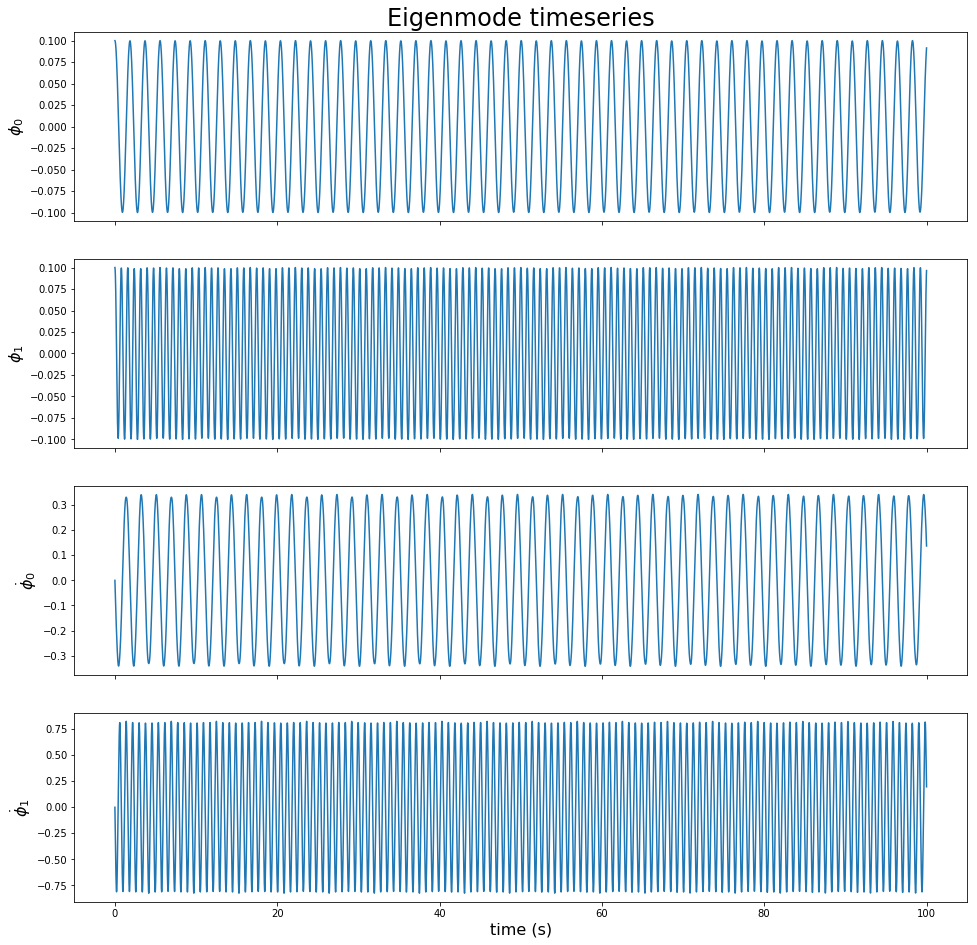

In [221]:
foo.time_series_plots(eigenmodes=True)

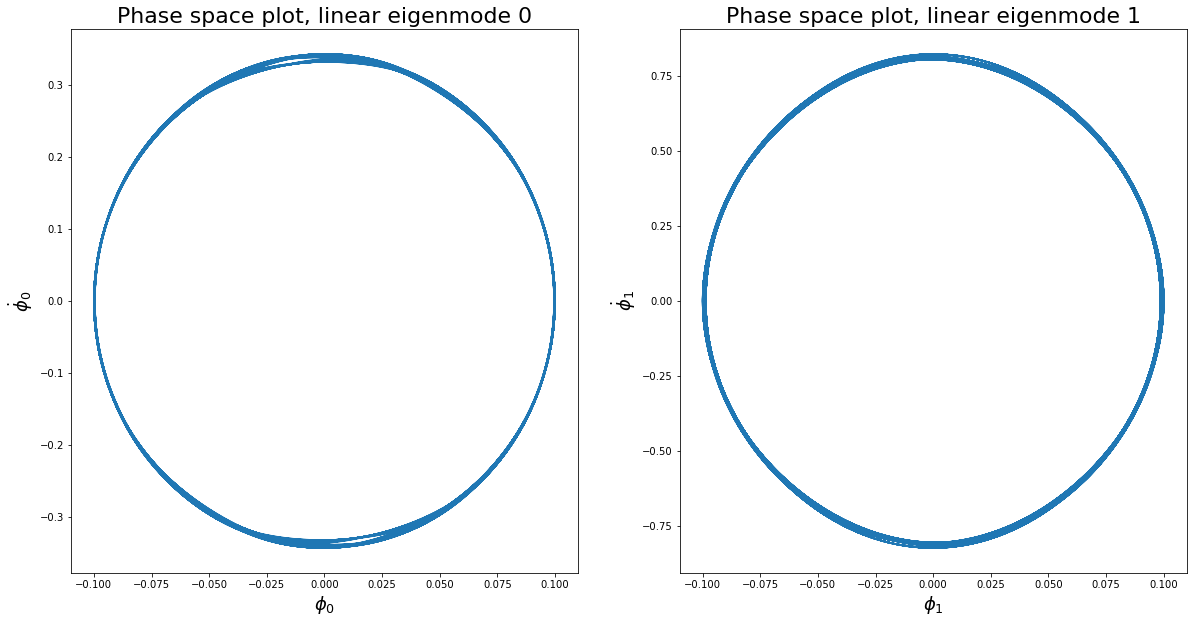

In [222]:
foo.phase_plots(eigenmodes=True)

In [62]:
HTML(foo.anim.to_html5_video())

### Todos:
1. ~~specify initial conditions in terms of eigenmodes~~
2. ~~time series plots~~
4. serialization
2. ~~eigenmode time series plots~~
2. Frequencies
3. Energy diagnostics
4. poincare section
5. damping?
6. time dependent forcing?
7. fully annotate plots


### Serialization

We want to store results in an HDF5 archive. We will also need to be able to restore from the archive. Questions:
1. What exactly do we need to store?
2. How do we organize within the archive?
3. What sort of interface is needed for restoring?

In [223]:
help(np.fft)

Help on package numpy.fft in numpy:

NAME
    numpy.fft

DESCRIPTION
    Discrete Fourier Transform (:mod:`numpy.fft`)
    
    .. currentmodule:: numpy.fft
    
    Standard FFTs
    -------------
    
    .. autosummary::
       :toctree: generated/
    
       fft       Discrete Fourier transform.
       ifft      Inverse discrete Fourier transform.
       fft2      Discrete Fourier transform in two dimensions.
       ifft2     Inverse discrete Fourier transform in two dimensions.
       fftn      Discrete Fourier transform in N-dimensions.
       ifftn     Inverse discrete Fourier transform in N dimensions.
    
    Real FFTs
    ---------
    
    .. autosummary::
       :toctree: generated/
    
       rfft      Real discrete Fourier transform.
       irfft     Inverse real discrete Fourier transform.
       rfft2     Real discrete Fourier transform in two dimensions.
       irfft2    Inverse real discrete Fourier transform in two dimensions.
       rfftn     Real discrete Fourie